In [18]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
np.random.seed(50)   
tf.random.set_seed(50)

In [19]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [21]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt       C_filt
0        86444.183014  5713.739611
1        86444.358094  5713.748279
2        86442.647757  5713.750421
3        86419.380962  5713.758606
4        86414.552286  5713.772870
...               ...          ...
75994    81488.107323  5720.364457
75995    81375.846782  5720.365210
75996    81263.154871  5720.384980
75997    81137.502620  5720.393775
75998    80982.695515  5720.397332

[75999 rows x 2 columns]
Target Data:
              SS     V_filt
0      5.893849  10.577261
1      5.893360  10.282278
2      5.893242  10.050505
3      5.893039   9.903014
4      5.892528   9.945154
...         ...        ...
75994  5.850977   0.674248
75995  5.851531   0.653177
75996  5.852108   0.863880
75997  5.852526   0.716388
75998  5.852725   0.863880

[75999 rows x 2 columns]


In [22]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (75699, 300, 2)
Target shape (SS), Y =  (75699,)
Target shape (V), Y =  (75699,)
After reshaping, X =  (75699, 600)


In [23]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Training Data Percentage 
X_train = X_train[0:53199] 
Y_train_SS = Y_train_SS[0:53199]
Y_train_V = Y_train_V[0:53199]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 52989
Validation samples: 7570
Testing samples: 15140


In [24]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [25]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [26]:
# Define MLP
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate 
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [27]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 64)           8256        ['dense_7[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 32)           2080        ['dense_8[0][0]']                
                                                                                            

Train on 52989 samples, validate on 7570 samples
Epoch 1/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0310 - dense_12_loss: 0.0250 - dense_13_loss: 0.0061 - dense_12_mse: 0.0250 - dense_13_mse: 0.0061

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.02685, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 7s 135us/sample - loss: 0.0310 - dense_12_loss: 0.0250 - dense_13_loss: 0.0060 - dense_12_mse: 0.0250 - dense_13_mse: 0.0061 - val_loss: 0.0268 - val_dense_12_loss: 0.0203 - val_dense_13_loss: 0.0065 - val_dense_12_mse: 0.0204 - val_dense_13_mse: 0.0065
Epoch 2/100
52864/52989 [============================>.] - ETA: 0s - loss: 0.0125 - dense_12_loss: 0.0094 - dense_13_loss: 0.0031 - dense_12_mse: 0.0094 - dense_13_mse: 0.0031
Epoch 2: val_loss improved from 0.02685 to 0.02296, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 101us/sample - loss: 0.0125 - dense_12_loss: 0.0094 - dense_13_loss: 0.0031 - dense_12_mse: 0.0094 - dense_13_mse: 0.0031 - val_loss: 0.0230 - val_dense_12_loss: 0.0174 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0175 - val_dense_13_mse: 0.0055
Epoch 3/100
52768/52989 [============================>.] - ETA: 0s - loss: 0.0112 - dense_12_loss: 0.0083 - dense_13_loss: 0.0030 - dense_12_mse: 0.0083 - dense_13_mse: 0.0030
Epoch 3: val_loss improved from 0.02296 to 0.02249, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 106us/sample - loss: 0.0112 - dense_12_loss: 0.0083 - dense_13_loss: 0.0030 - dense_12_mse: 0.0083 - dense_13_mse: 0.0030 - val_loss: 0.0225 - val_dense_12_loss: 0.0169 - val_dense_13_loss: 0.0056 - val_dense_12_mse: 0.0169 - val_dense_13_mse: 0.0056
Epoch 4/100
52256/52989 [============================>.] - ETA: 0s - loss: 0.0107 - dense_12_loss: 0.0077 - dense_13_loss: 0.0030 - dense_12_mse: 0.0077 - dense_13_mse: 0.0030
Epoch 4: val_loss improved from 0.02249 to 0.01925, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 102us/sample - loss: 0.0107 - dense_12_loss: 0.0077 - dense_13_loss: 0.0030 - dense_12_mse: 0.0077 - dense_13_mse: 0.0030 - val_loss: 0.0193 - val_dense_12_loss: 0.0137 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0137 - val_dense_13_mse: 0.0055
Epoch 5/100
52512/52989 [============================>.] - ETA: 0s - loss: 0.0097 - dense_12_loss: 0.0067 - dense_13_loss: 0.0030 - dense_12_mse: 0.0067 - dense_13_mse: 0.0030
Epoch 5: val_loss improved from 0.01925 to 0.01639, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 7s 132us/sample - loss: 0.0096 - dense_12_loss: 0.0067 - dense_13_loss: 0.0030 - dense_12_mse: 0.0067 - dense_13_mse: 0.0030 - val_loss: 0.0164 - val_dense_12_loss: 0.0109 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0109 - val_dense_13_mse: 0.0055
Epoch 6/100
52288/52989 [============================>.] - ETA: 0s - loss: 0.0085 - dense_12_loss: 0.0056 - dense_13_loss: 0.0029 - dense_12_mse: 0.0056 - dense_13_mse: 0.0029
Epoch 6: val_loss did not improve from 0.01639
52989/52989 [==============================] - 5s 92us/sample - loss: 0.0085 - dense_12_loss: 0.0056 - dense_13_loss: 0.0030 - dense_12_mse: 0.0056 - dense_13_mse: 0.0030 - val_loss: 0.0165 - val_dense_12_loss: 0.0110 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0110 - val_dense_13_mse: 0.0054
Epoch 7/100
52480/52989 [============================>.] - ETA: 0s - loss: 0.0079 - dense_12_loss: 0.0050 - dense_13_loss: 0.0029 - dense_12_mse: 0.0050 - dense_13_mse: 0.0029


52989/52989 [==============================] - 6s 105us/sample - loss: 0.0079 - dense_12_loss: 0.0050 - dense_13_loss: 0.0030 - dense_12_mse: 0.0050 - dense_13_mse: 0.0030 - val_loss: 0.0138 - val_dense_12_loss: 0.0083 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0083 - val_dense_13_mse: 0.0055
Epoch 8/100
52448/52989 [============================>.] - ETA: 0s - loss: 0.0074 - dense_12_loss: 0.0044 - dense_13_loss: 0.0029 - dense_12_mse: 0.0044 - dense_13_mse: 0.0029
Epoch 8: val_loss improved from 0.01382 to 0.01356, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 103us/sample - loss: 0.0074 - dense_12_loss: 0.0044 - dense_13_loss: 0.0030 - dense_12_mse: 0.0044 - dense_13_mse: 0.0030 - val_loss: 0.0136 - val_dense_12_loss: 0.0081 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0081 - val_dense_13_mse: 0.0055
Epoch 9/100
52864/52989 [============================>.] - ETA: 0s - loss: 0.0070 - dense_12_loss: 0.0040 - dense_13_loss: 0.0030 - dense_12_mse: 0.0040 - dense_13_mse: 0.0030
Epoch 9: val_loss improved from 0.01356 to 0.01186, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 111us/sample - loss: 0.0070 - dense_12_loss: 0.0040 - dense_13_loss: 0.0029 - dense_12_mse: 0.0040 - dense_13_mse: 0.0029 - val_loss: 0.0119 - val_dense_12_loss: 0.0064 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0063 - val_dense_13_mse: 0.0055
Epoch 10/100
52288/52989 [============================>.] - ETA: 0s - loss: 0.0067 - dense_12_loss: 0.0038 - dense_13_loss: 0.0029 - dense_12_mse: 0.0038 - dense_13_mse: 0.0029
Epoch 10: val_loss improved from 0.01186 to 0.01178, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 104us/sample - loss: 0.0067 - dense_12_loss: 0.0038 - dense_13_loss: 0.0030 - dense_12_mse: 0.0038 - dense_13_mse: 0.0030 - val_loss: 0.0118 - val_dense_12_loss: 0.0063 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0063 - val_dense_13_mse: 0.0055
Epoch 11/100
52736/52989 [============================>.] - ETA: 0s - loss: 0.0064 - dense_12_loss: 0.0034 - dense_13_loss: 0.0030 - dense_12_mse: 0.0034 - dense_13_mse: 0.0030
Epoch 11: val_loss improved from 0.01178 to 0.01095, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 104us/sample - loss: 0.0064 - dense_12_loss: 0.0034 - dense_13_loss: 0.0029 - dense_12_mse: 0.0034 - dense_13_mse: 0.0029 - val_loss: 0.0109 - val_dense_12_loss: 0.0054 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0054 - val_dense_13_mse: 0.0055
Epoch 12/100
52608/52989 [============================>.] - ETA: 0s - loss: 0.0062 - dense_12_loss: 0.0032 - dense_13_loss: 0.0030 - dense_12_mse: 0.0032 - dense_13_mse: 0.0030
Epoch 12: val_loss improved from 0.01095 to 0.01067, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 108us/sample - loss: 0.0061 - dense_12_loss: 0.0032 - dense_13_loss: 0.0029 - dense_12_mse: 0.0032 - dense_13_mse: 0.0029 - val_loss: 0.0107 - val_dense_12_loss: 0.0051 - val_dense_13_loss: 0.0056 - val_dense_12_mse: 0.0051 - val_dense_13_mse: 0.0056
Epoch 13/100
52480/52989 [============================>.] - ETA: 0s - loss: 0.0060 - dense_12_loss: 0.0030 - dense_13_loss: 0.0029 - dense_12_mse: 0.0030 - dense_13_mse: 0.0029
Epoch 13: val_loss did not improve from 0.01067
52989/52989 [==============================] - 4s 77us/sample - loss: 0.0060 - dense_12_loss: 0.0031 - dense_13_loss: 0.0029 - dense_12_mse: 0.0031 - dense_13_mse: 0.0029 - val_loss: 0.0133 - val_dense_12_loss: 0.0079 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0079 - val_dense_13_mse: 0.0054
Epoch 14/100
52512/52989 [============================>.] - ETA: 0s - loss: 0.0058 - dense_12_loss: 0.0029 - dense_13_loss: 0.0029 - dense_12_mse: 0.0029 - dense_13_mse: 0.00

52989/52989 [==============================] - 6s 109us/sample - loss: 0.0058 - dense_12_loss: 0.0029 - dense_13_loss: 0.0029 - dense_12_mse: 0.0029 - dense_13_mse: 0.0029 - val_loss: 0.0104 - val_dense_12_loss: 0.0049 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0049 - val_dense_13_mse: 0.0055
Epoch 15/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0057 - dense_12_loss: 0.0027 - dense_13_loss: 0.0029 - dense_12_mse: 0.0027 - dense_13_mse: 0.0029
Epoch 15: val_loss did not improve from 0.01037
52989/52989 [==============================] - 4s 79us/sample - loss: 0.0057 - dense_12_loss: 0.0027 - dense_13_loss: 0.0029 - dense_12_mse: 0.0027 - dense_13_mse: 0.0029 - val_loss: 0.0118 - val_dense_12_loss: 0.0063 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0063 - val_dense_13_mse: 0.0054
Epoch 16/100
52448/52989 [============================>.] - ETA: 0s - loss: 0.0054 - dense_12_loss: 0.0025 - dense_13_loss: 0.0029 - dense_12_mse: 0.0025 - dense_13_mse: 0.00

52989/52989 [==============================] - 5s 103us/sample - loss: 0.0054 - dense_12_loss: 0.0025 - dense_13_loss: 0.0029 - dense_12_mse: 0.0025 - dense_13_mse: 0.0029 - val_loss: 0.0100 - val_dense_12_loss: 0.0046 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0046 - val_dense_13_mse: 0.0055
Epoch 17/100
52448/52989 [============================>.] - ETA: 0s - loss: 0.0053 - dense_12_loss: 0.0024 - dense_13_loss: 0.0029 - dense_12_mse: 0.0024 - dense_13_mse: 0.0029
Epoch 17: val_loss improved from 0.01003 to 0.00993, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 104us/sample - loss: 0.0053 - dense_12_loss: 0.0024 - dense_13_loss: 0.0029 - dense_12_mse: 0.0024 - dense_13_mse: 0.0029 - val_loss: 0.0099 - val_dense_12_loss: 0.0045 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0045 - val_dense_13_mse: 0.0054
Epoch 18/100
52288/52989 [============================>.] - ETA: 0s - loss: 0.0052 - dense_12_loss: 0.0023 - dense_13_loss: 0.0029 - dense_12_mse: 0.0023 - dense_13_mse: 0.0029
Epoch 18: val_loss improved from 0.00993 to 0.00976, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 104us/sample - loss: 0.0052 - dense_12_loss: 0.0023 - dense_13_loss: 0.0029 - dense_12_mse: 0.0023 - dense_13_mse: 0.0029 - val_loss: 0.0098 - val_dense_12_loss: 0.0043 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0043 - val_dense_13_mse: 0.0054
Epoch 19/100
52640/52989 [============================>.] - ETA: 0s - loss: 0.0052 - dense_12_loss: 0.0022 - dense_13_loss: 0.0029 - dense_12_mse: 0.0022 - dense_13_mse: 0.0029
Epoch 19: val_loss did not improve from 0.00976
52989/52989 [==============================] - 4s 77us/sample - loss: 0.0052 - dense_12_loss: 0.0022 - dense_13_loss: 0.0029 - dense_12_mse: 0.0022 - dense_13_mse: 0.0029 - val_loss: 0.0098 - val_dense_12_loss: 0.0044 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0044 - val_dense_13_mse: 0.0054
Epoch 20/100
52704/52989 [============================>.] - ETA: 0s - loss: 0.0050 - dense_12_loss: 0.0021 - dense_13_loss: 0.0029 - dense_12_mse: 0.0021 - dense_13_mse: 0.00

52989/52989 [==============================] - 6s 106us/sample - loss: 0.0050 - dense_12_loss: 0.0021 - dense_13_loss: 0.0029 - dense_12_mse: 0.0021 - dense_13_mse: 0.0029 - val_loss: 0.0096 - val_dense_12_loss: 0.0042 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0042 - val_dense_13_mse: 0.0054
Epoch 21/100
52352/52989 [============================>.] - ETA: 0s - loss: 0.0050 - dense_12_loss: 0.0021 - dense_13_loss: 0.0029 - dense_12_mse: 0.0021 - dense_13_mse: 0.0029
Epoch 21: val_loss improved from 0.00960 to 0.00899, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 112us/sample - loss: 0.0050 - dense_12_loss: 0.0021 - dense_13_loss: 0.0029 - dense_12_mse: 0.0021 - dense_13_mse: 0.0029 - val_loss: 0.0090 - val_dense_12_loss: 0.0035 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0035 - val_dense_13_mse: 0.0055
Epoch 22/100
52960/52989 [============================>.] - ETA: 0s - loss: 0.0050 - dense_12_loss: 0.0020 - dense_13_loss: 0.0029 - dense_12_mse: 0.0020 - dense_13_mse: 0.0029
Epoch 22: val_loss did not improve from 0.00899
52989/52989 [==============================] - 4s 82us/sample - loss: 0.0050 - dense_12_loss: 0.0020 - dense_13_loss: 0.0029 - dense_12_mse: 0.0020 - dense_13_mse: 0.0029 - val_loss: 0.0090 - val_dense_12_loss: 0.0036 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 0.0054
Epoch 23/100
52416/52989 [============================>.] - ETA: 0s - loss: 0.0049 - dense_12_loss: 0.0020 - dense_13_loss: 0.0029 - dense_12_mse: 0.0020 - dense_13_mse: 0.00

52989/52989 [==============================] - 6s 107us/sample - loss: 0.0049 - dense_12_loss: 0.0020 - dense_13_loss: 0.0029 - dense_12_mse: 0.0020 - dense_13_mse: 0.0029 - val_loss: 0.0090 - val_dense_12_loss: 0.0036 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 0.0054
Epoch 24/100
52512/52989 [============================>.] - ETA: 0s - loss: 0.0049 - dense_12_loss: 0.0019 - dense_13_loss: 0.0029 - dense_12_mse: 0.0019 - dense_13_mse: 0.0029
Epoch 24: val_loss improved from 0.00899 to 0.00887, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 106us/sample - loss: 0.0048 - dense_12_loss: 0.0019 - dense_13_loss: 0.0029 - dense_12_mse: 0.0019 - dense_13_mse: 0.0029 - val_loss: 0.0089 - val_dense_12_loss: 0.0034 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0034 - val_dense_13_mse: 0.0055
Epoch 25/100
52320/52989 [============================>.] - ETA: 0s - loss: 0.0048 - dense_12_loss: 0.0019 - dense_13_loss: 0.0029 - dense_12_mse: 0.0019 - dense_13_mse: 0.0029
Epoch 25: val_loss did not improve from 0.00887
52989/52989 [==============================] - 4s 78us/sample - loss: 0.0049 - dense_12_loss: 0.0019 - dense_13_loss: 0.0029 - dense_12_mse: 0.0019 - dense_13_mse: 0.0029 - val_loss: 0.0108 - val_dense_12_loss: 0.0054 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0054 - val_dense_13_mse: 0.0054
Epoch 26/100
52989/52989 [==============================] - ETA: 0s - loss: 0.0048 - dense_12_loss: 0.0019 - dense_13_loss: 0.0029 - dense_12_mse: 0.0019 - dense_13_mse: 0.00

52989/52989 [==============================] - 6s 105us/sample - loss: 0.0048 - dense_12_loss: 0.0019 - dense_13_loss: 0.0029 - dense_12_mse: 0.0019 - dense_13_mse: 0.0029 - val_loss: 0.0089 - val_dense_12_loss: 0.0034 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0034 - val_dense_13_mse: 0.0054
Epoch 27/100
52704/52989 [============================>.] - ETA: 0s - loss: 0.0047 - dense_12_loss: 0.0018 - dense_13_loss: 0.0029 - dense_12_mse: 0.0018 - dense_13_mse: 0.0029
Epoch 27: val_loss improved from 0.00886 to 0.00868, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 110us/sample - loss: 0.0047 - dense_12_loss: 0.0018 - dense_13_loss: 0.0029 - dense_12_mse: 0.0018 - dense_13_mse: 0.0029 - val_loss: 0.0087 - val_dense_12_loss: 0.0032 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0032 - val_dense_13_mse: 0.0055
Epoch 28/100
52352/52989 [============================>.] - ETA: 0s - loss: 0.0048 - dense_12_loss: 0.0018 - dense_13_loss: 0.0029 - dense_12_mse: 0.0018 - dense_13_mse: 0.0029
Epoch 28: val_loss did not improve from 0.00868
52989/52989 [==============================] - 4s 80us/sample - loss: 0.0048 - dense_12_loss: 0.0018 - dense_13_loss: 0.0029 - dense_12_mse: 0.0018 - dense_13_mse: 0.0029 - val_loss: 0.0090 - val_dense_12_loss: 0.0035 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0035 - val_dense_13_mse: 0.0055
Epoch 29/100
52704/52989 [============================>.] - ETA: 0s - loss: 0.0039 - dense_12_loss: 0.0019 - dense_13_loss: 0.0020 - dense_12_mse: 0.0019 - dense_13_mse: 0.00

52989/52989 [==============================] - 6s 106us/sample - loss: 0.0039 - dense_12_loss: 0.0019 - dense_13_loss: 0.0020 - dense_12_mse: 0.0019 - dense_13_mse: 0.0020 - val_loss: 0.0064 - val_dense_12_loss: 0.0037 - val_dense_13_loss: 0.0026 - val_dense_12_mse: 0.0037 - val_dense_13_mse: 0.0026
Epoch 30/100
52736/52989 [============================>.] - ETA: 0s - loss: 0.0031 - dense_12_loss: 0.0019 - dense_13_loss: 0.0012 - dense_12_mse: 0.0019 - dense_13_mse: 0.0012
Epoch 30: val_loss improved from 0.00639 to 0.00587, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 8s 142us/sample - loss: 0.0031 - dense_12_loss: 0.0019 - dense_13_loss: 0.0012 - dense_12_mse: 0.0019 - dense_13_mse: 0.0012 - val_loss: 0.0059 - val_dense_12_loss: 0.0036 - val_dense_13_loss: 0.0023 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 0.0023
Epoch 31/100
52448/52989 [============================>.] - ETA: 0s - loss: 0.0029 - dense_12_loss: 0.0019 - dense_13_loss: 0.0010 - dense_12_mse: 0.0019 - dense_13_mse: 0.0010
Epoch 31: val_loss did not improve from 0.00587
52989/52989 [==============================] - 4s 80us/sample - loss: 0.0029 - dense_12_loss: 0.0019 - dense_13_loss: 0.0010 - dense_12_mse: 0.0019 - dense_13_mse: 0.0010 - val_loss: 0.0090 - val_dense_12_loss: 0.0064 - val_dense_13_loss: 0.0026 - val_dense_12_mse: 0.0064 - val_dense_13_mse: 0.0026
Epoch 32/100
52704/52989 [============================>.] - ETA: 0s - loss: 0.0027 - dense_12_loss: 0.0018 - dense_13_loss: 9.3395e-04 - dense_12_mse: 0.0018 - dense_13_mse: 

52989/52989 [==============================] - 6s 106us/sample - loss: 0.0026 - dense_12_loss: 0.0017 - dense_13_loss: 8.8719e-04 - dense_12_mse: 0.0017 - dense_13_mse: 8.8723e-04 - val_loss: 0.0049 - val_dense_12_loss: 0.0036 - val_dense_13_loss: 0.0012 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 0.0012
Epoch 34/100
52608/52989 [============================>.] - ETA: 0s - loss: 0.0026 - dense_12_loss: 0.0017 - dense_13_loss: 8.5273e-04 - dense_12_mse: 0.0017 - dense_13_mse: 8.5273e-04
Epoch 34: val_loss improved from 0.00487 to 0.00487, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 112us/sample - loss: 0.0026 - dense_12_loss: 0.0017 - dense_13_loss: 8.4776e-04 - dense_12_mse: 0.0017 - dense_13_mse: 8.4781e-04 - val_loss: 0.0049 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 0.0016 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 0.0016
Epoch 35/100
52448/52989 [============================>.] - ETA: 0s - loss: 0.0025 - dense_12_loss: 0.0017 - dense_13_loss: 7.5632e-04 - dense_12_mse: 0.0017 - dense_13_mse: 7.5632e-04
Epoch 35: val_loss did not improve from 0.00487
52989/52989 [==============================] - 4s 79us/sample - loss: 0.0025 - dense_12_loss: 0.0017 - dense_13_loss: 7.5971e-04 - dense_12_mse: 0.0017 - dense_13_mse: 7.5962e-04 - val_loss: 0.0057 - val_dense_12_loss: 0.0039 - val_dense_13_loss: 0.0018 - val_dense_12_mse: 0.0039 - val_dense_13_mse: 0.0018
Epoch 36/100
52864/52989 [============================>.] - ETA: 0s - loss: 0.0025 - dense_12_loss: 0.0017 - dense_13_loss: 7.7451e-04 - dense_12_mse:

52989/52989 [==============================] - 6s 104us/sample - loss: 0.0025 - dense_12_loss: 0.0017 - dense_13_loss: 7.7379e-04 - dense_12_mse: 0.0017 - dense_13_mse: 7.7380e-04 - val_loss: 0.0048 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 0.0015 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 0.0015
Epoch 37/100
52480/52989 [============================>.] - ETA: 0s - loss: 0.0023 - dense_12_loss: 0.0016 - dense_13_loss: 7.0428e-04 - dense_12_mse: 0.0016 - dense_13_mse: 7.0428e-04
Epoch 37: val_loss improved from 0.00478 to 0.00449, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 105us/sample - loss: 0.0023 - dense_12_loss: 0.0016 - dense_13_loss: 6.9952e-04 - dense_12_mse: 0.0016 - dense_13_mse: 6.9956e-04 - val_loss: 0.0045 - val_dense_12_loss: 0.0036 - val_dense_13_loss: 8.6990e-04 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 8.6620e-04
Epoch 38/100
52512/52989 [============================>.] - ETA: 0s - loss: 0.0024 - dense_12_loss: 0.0017 - dense_13_loss: 7.2992e-04 - dense_12_mse: 0.0017 - dense_13_mse: 7.2992e-04
Epoch 38: val_loss did not improve from 0.00449
52989/52989 [==============================] - 4s 82us/sample - loss: 0.0024 - dense_12_loss: 0.0017 - dense_13_loss: 7.3218e-04 - dense_12_mse: 0.0017 - dense_13_mse: 7.3205e-04 - val_loss: 0.0045 - val_dense_12_loss: 0.0035 - val_dense_13_loss: 9.9520e-04 - val_dense_12_mse: 0.0035 - val_dense_13_mse: 9.9698e-04
Epoch 39/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0023 - dense_12_loss: 0.0016 - dense_13_loss: 6.9993e-04

52989/52989 [==============================] - 6s 107us/sample - loss: 0.0023 - dense_12_loss: 0.0016 - dense_13_loss: 6.8037e-04 - dense_12_mse: 0.0016 - dense_13_mse: 6.8033e-04 - val_loss: 0.0042 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 9.2189e-04 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 9.2352e-04
Epoch 42/100
52800/52989 [============================>.] - ETA: 0s - loss: 0.0022 - dense_12_loss: 0.0016 - dense_13_loss: 6.4500e-04 - dense_12_mse: 0.0016 - dense_13_mse: 6.4500e-04
Epoch 42: val_loss improved from 0.00423 to 0.00402, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 107us/sample - loss: 0.0022 - dense_12_loss: 0.0016 - dense_13_loss: 6.4344e-04 - dense_12_mse: 0.0016 - dense_13_mse: 6.4346e-04 - val_loss: 0.0040 - val_dense_12_loss: 0.0031 - val_dense_13_loss: 9.7028e-04 - val_dense_12_mse: 0.0031 - val_dense_13_mse: 9.6959e-04
Epoch 43/100
52960/52989 [============================>.] - ETA: 0s - loss: 0.0022 - dense_12_loss: 0.0015 - dense_13_loss: 6.3000e-04 - dense_12_mse: 0.0015 - dense_13_mse: 6.3000e-04
Epoch 43: val_loss did not improve from 0.00402
52989/52989 [==============================] - 4s 80us/sample - loss: 0.0022 - dense_12_loss: 0.0015 - dense_13_loss: 6.2965e-04 - dense_12_mse: 0.0015 - dense_13_mse: 6.2968e-04 - val_loss: 0.0050 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 0.0017 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 0.0016
Epoch 44/100
52736/52989 [============================>.] - ETA: 0s - loss: 0.0021 - dense_12_loss: 0.0015 - dense_13_loss: 5.8896e-04 - dense

52989/52989 [==============================] - 6s 111us/sample - loss: 0.0018 - dense_12_loss: 0.0013 - dense_13_loss: 4.8026e-04 - dense_12_mse: 0.0013 - dense_13_mse: 4.8028e-04 - val_loss: 0.0040 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 6.6377e-04 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 6.6494e-04
Epoch 60/100
52704/52989 [============================>.] - ETA: 0s - loss: 0.0018 - dense_12_loss: 0.0013 - dense_13_loss: 4.8879e-04 - dense_12_mse: 0.0013 - dense_13_mse: 4.8879e-04
Epoch 60: val_loss improved from 0.00399 to 0.00394, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 104us/sample - loss: 0.0018 - dense_12_loss: 0.0013 - dense_13_loss: 4.8719e-04 - dense_12_mse: 0.0013 - dense_13_mse: 4.8720e-04 - val_loss: 0.0039 - val_dense_12_loss: 0.0032 - val_dense_13_loss: 7.2724e-04 - val_dense_12_mse: 0.0032 - val_dense_13_mse: 7.2856e-04
Epoch 61/100
52989/52989 [==============================] - ETA: 0s - loss: 0.0018 - dense_12_loss: 0.0013 - dense_13_loss: 4.6128e-04 - dense_12_mse: 0.0013 - dense_13_mse: 4.6129e-04
Epoch 61: val_loss did not improve from 0.00394
52989/52989 [==============================] - 4s 79us/sample - loss: 0.0018 - dense_12_loss: 0.0013 - dense_13_loss: 4.6128e-04 - dense_12_mse: 0.0013 - dense_13_mse: 4.6129e-04 - val_loss: 0.0049 - val_dense_12_loss: 0.0041 - val_dense_13_loss: 7.5582e-04 - val_dense_12_mse: 0.0041 - val_dense_13_mse: 7.5503e-04
Epoch 62/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0018 - dense_12_loss: 0.0013 - dense_13_loss: 4.6738e-04

52989/52989 [==============================] - 7s 123us/sample - loss: 0.0018 - dense_12_loss: 0.0013 - dense_13_loss: 4.7703e-04 - dense_12_mse: 0.0013 - dense_13_mse: 4.7706e-04 - val_loss: 0.0036 - val_dense_12_loss: 0.0030 - val_dense_13_loss: 6.0915e-04 - val_dense_12_mse: 0.0030 - val_dense_13_mse: 6.1024e-04
Epoch 65/100
52896/52989 [============================>.] - ETA: 0s - loss: 0.0017 - dense_12_loss: 0.0013 - dense_13_loss: 4.4050e-04 - dense_12_mse: 0.0013 - dense_13_mse: 4.4050e-04
Epoch 65: val_loss did not improve from 0.00364
52989/52989 [==============================] - 4s 80us/sample - loss: 0.0017 - dense_12_loss: 0.0013 - dense_13_loss: 4.4072e-04 - dense_12_mse: 0.0013 - dense_13_mse: 4.4073e-04 - val_loss: 0.0051 - val_dense_12_loss: 0.0043 - val_dense_13_loss: 8.0626e-04 - val_dense_12_mse: 0.0043 - val_dense_13_mse: 8.0720e-04
Epoch 66/100
52864/52989 [============================>.] - ETA: 0s - loss: 0.0017 - dense_12_loss: 0.0013 - dense_13_loss: 4.4793e-04

52989/52989 [==============================] - 6s 108us/sample - loss: 0.0015 - dense_12_loss: 0.0012 - dense_13_loss: 3.8511e-04 - dense_12_mse: 0.0012 - dense_13_mse: 3.8513e-04 - val_loss: 0.0034 - val_dense_12_loss: 0.0029 - val_dense_13_loss: 4.7844e-04 - val_dense_12_mse: 0.0029 - val_dense_13_mse: 4.7866e-04
Epoch 83/100
52352/52989 [============================>.] - ETA: 0s - loss: 0.0015 - dense_12_loss: 0.0011 - dense_13_loss: 3.7304e-04 - dense_12_mse: 0.0011 - dense_13_mse: 3.7304e-04
Epoch 83: val_loss did not improve from 0.00336
52989/52989 [==============================] - 4s 79us/sample - loss: 0.0015 - dense_12_loss: 0.0011 - dense_13_loss: 3.7065e-04 - dense_12_mse: 0.0011 - dense_13_mse: 3.7062e-04 - val_loss: 0.0041 - val_dense_12_loss: 0.0036 - val_dense_13_loss: 5.4688e-04 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 5.4785e-04
Epoch 84/100
52576/52989 [============================>.] - ETA: 0s - loss: 0.0015 - dense_12_loss: 0.0011 - dense_13_loss: 3.8003e-04

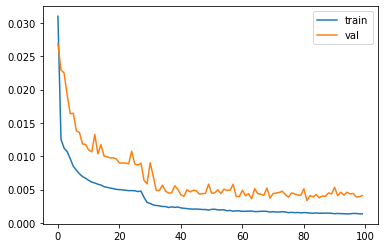

---Training time: 486.39312696 seconds ---


In [28]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto') 
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [29]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.96590, Train (V) - 0.91556
R2 scores: Validation (SS) - 0.91060, Validation (V) - 0.89095
R2 scores: Testing (SS) - 0.75628, Testing (V) - 0.79070
RMSE scores: Train (SS) - 0.02750, Train (V) - 0.01579
RMSE scores: Validation (SS) - 0.05937, Validation (V) - 0.02457
RMSE scores: Testing (SS) - 0.10627, Testing (V) - 0.03902


In [30]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [31]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

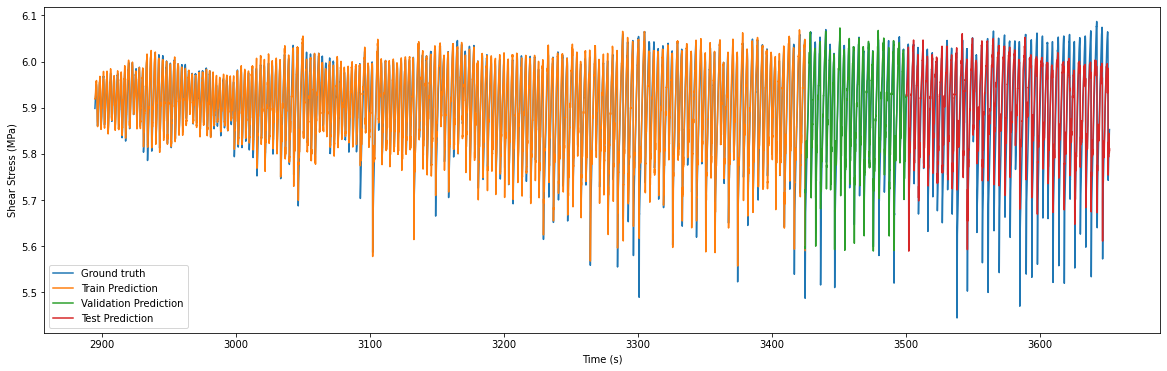

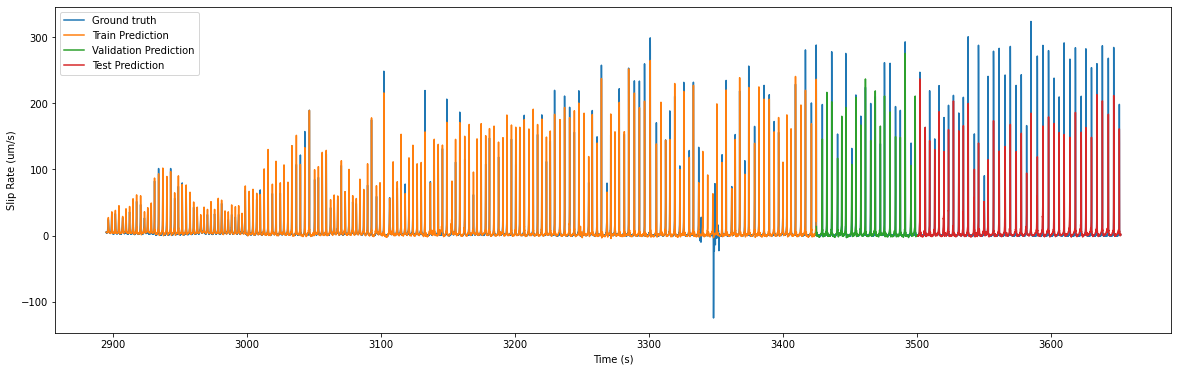

In [32]:
# Overall plot: SS & V
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[0:53199] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

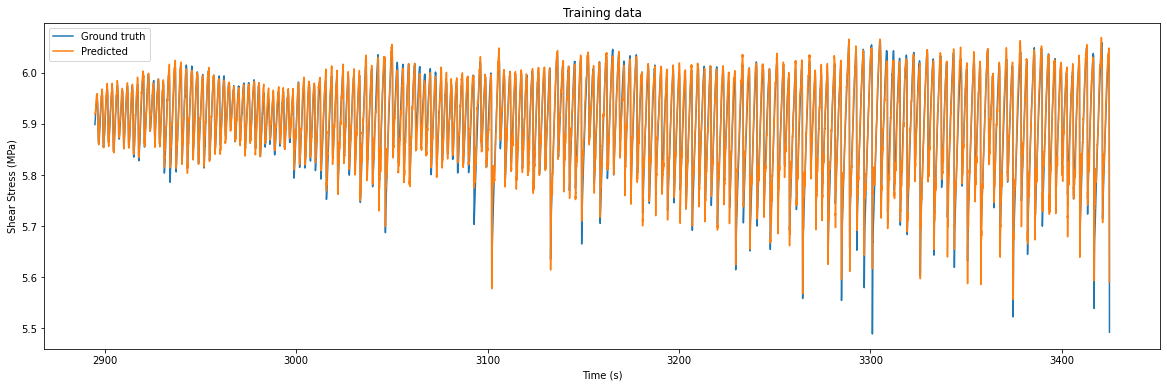

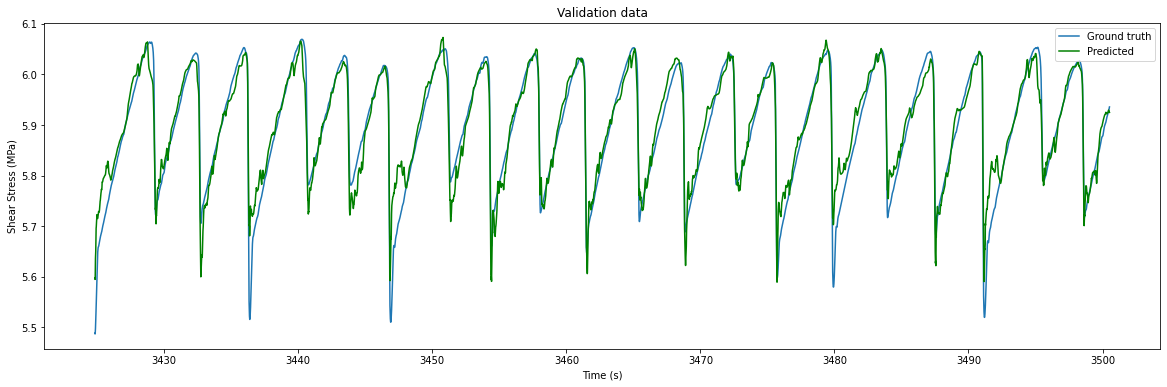

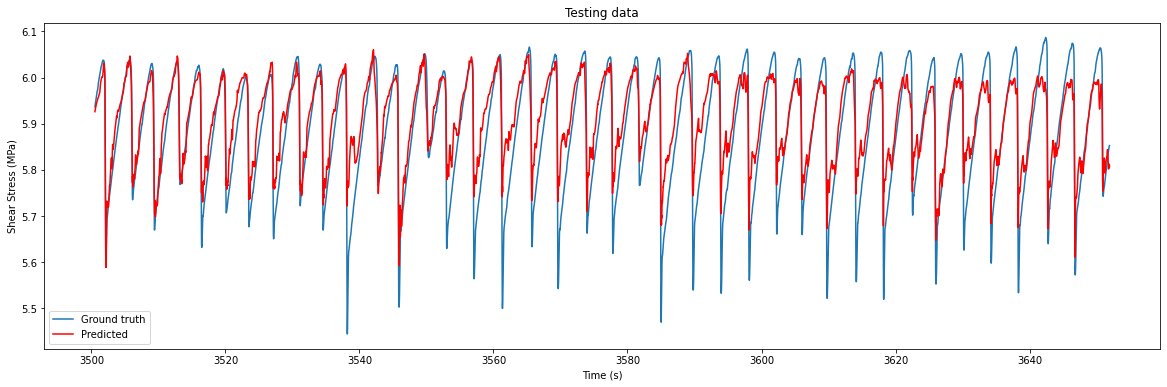

In [33]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

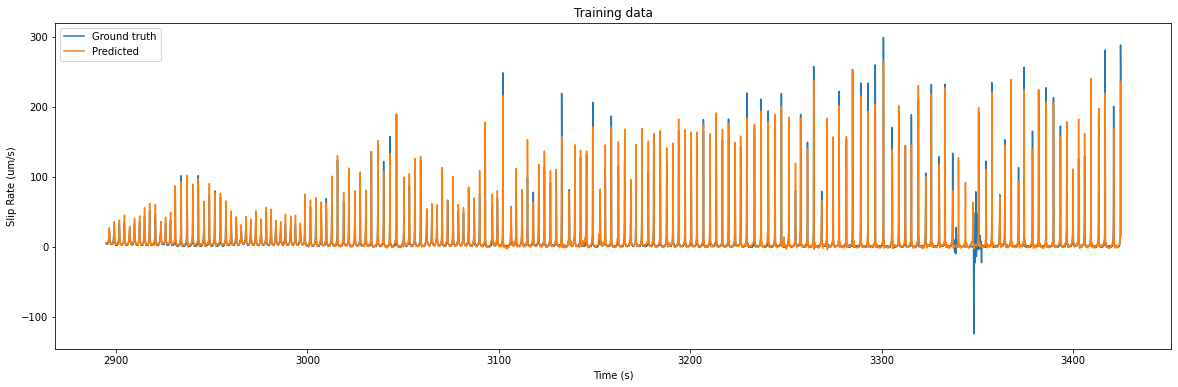

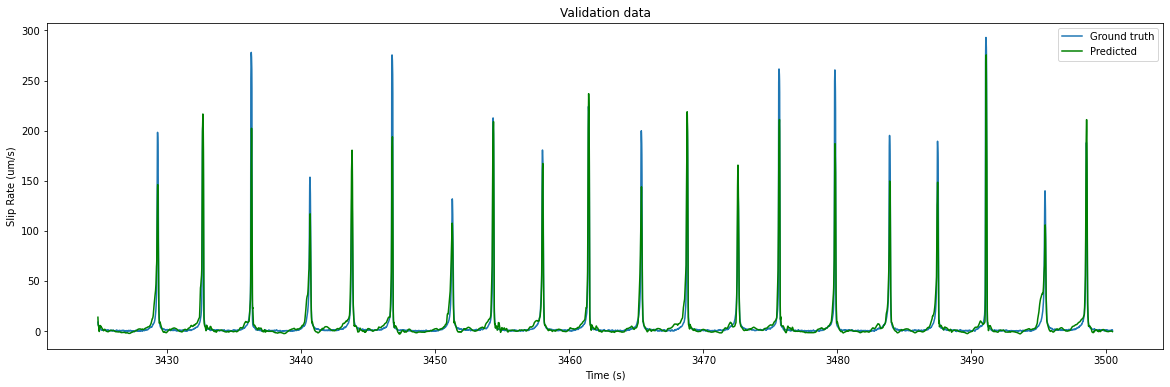

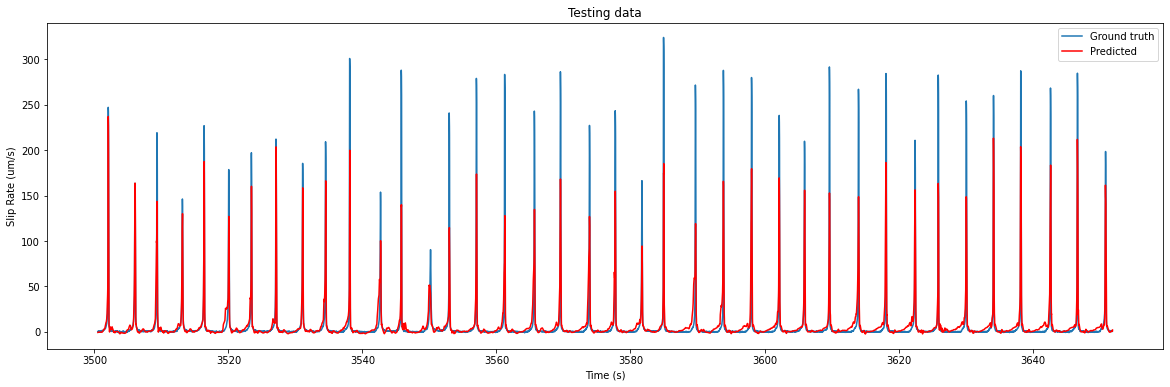

In [34]:
# # Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')